In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from datetime import datetime
import os
import glob


In [ ]:
# Path to folder with RACMO files
folder_path = "data"  # Replace with your actual folder path

# Files matching RACMO_*daily.txt
file_list = glob.glob(os.path.join(folder_path, "RACMO*daily*.txt"))

# Define expected column names
columns = [
    "year", "doy", "precip", "snowfall", "snowmelt", "runoff", 
    "t2m", "tskin", "corr"
]

df_list = []

for file in file_list:
    try:
        df = pd.read_csv(file, sep=r'\s+', engine='python', header=None, names=columns)
        # Ensure year and day of year are integers
        df["year"] = df["year"].astype(int)
        df["doy"] = df["doy"].astype(int)
        # Create datetime
        df["time"] = pd.to_datetime(df["year"] * 1000 + df["doy"], format="%Y%j")
        # Convert from Kelvin to Celsius
        df["t2m_C"] = df["t2m"] - 273.15
        df_list.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Merge all data
full_df = pd.concat(df_list, ignore_index=True).sort_values("time")
full_df = full_df[(full_df["time"] >= "1988-01-01") & (full_df["time"] <= "2020-12-31")]

In [58]:
# Set common limits
start_date = datetime(1988, 1, 1)
end_date = datetime(2020, 12, 31)

# Prepare filtered datasets
df_temp = full_df[["time", "t2m_C"]].copy()
df_1990 = full_df[full_df["time"].dt.year == 1990]
df_2014 = full_df[full_df["time"].dt.year == 2014]
df_snow_rain = full_df[(full_df["time"].dt.year >= 1990) & (full_df["time"].dt.year <= 2020)]
df_runoff_melt = full_df[(full_df["time"].dt.year >= 1990) & (full_df["time"].dt.year <= 2020)]

In [59]:
# Define the events
events = [
    {"start": datetime(1990, 6, 19), "end": datetime(1990, 8, 1), "label": "Event 1990"},
    {"start": datetime(2014, 7, 22), "end": datetime(2014, 8, 1), "label": "Event 2014"},
]

def draw_grey_bar(ax, start, end):
    ax.axvspan(start, end, color='grey', alpha=0.3)

def draw_red_arrow(ax, start, end):
    arrow_x = start + (end - start) / 2
    ylim = ax.get_ylim()
    arrow_y = ylim[1] + (ylim[1] - ylim[0]) * 0.05
    ax.annotate('', xy=(arrow_x, ylim[1]), xytext=(arrow_x, arrow_y),
                arrowprops=dict(facecolor='red', shrink=0.05, width=4, headwidth=10),
                annotation_clip=False)

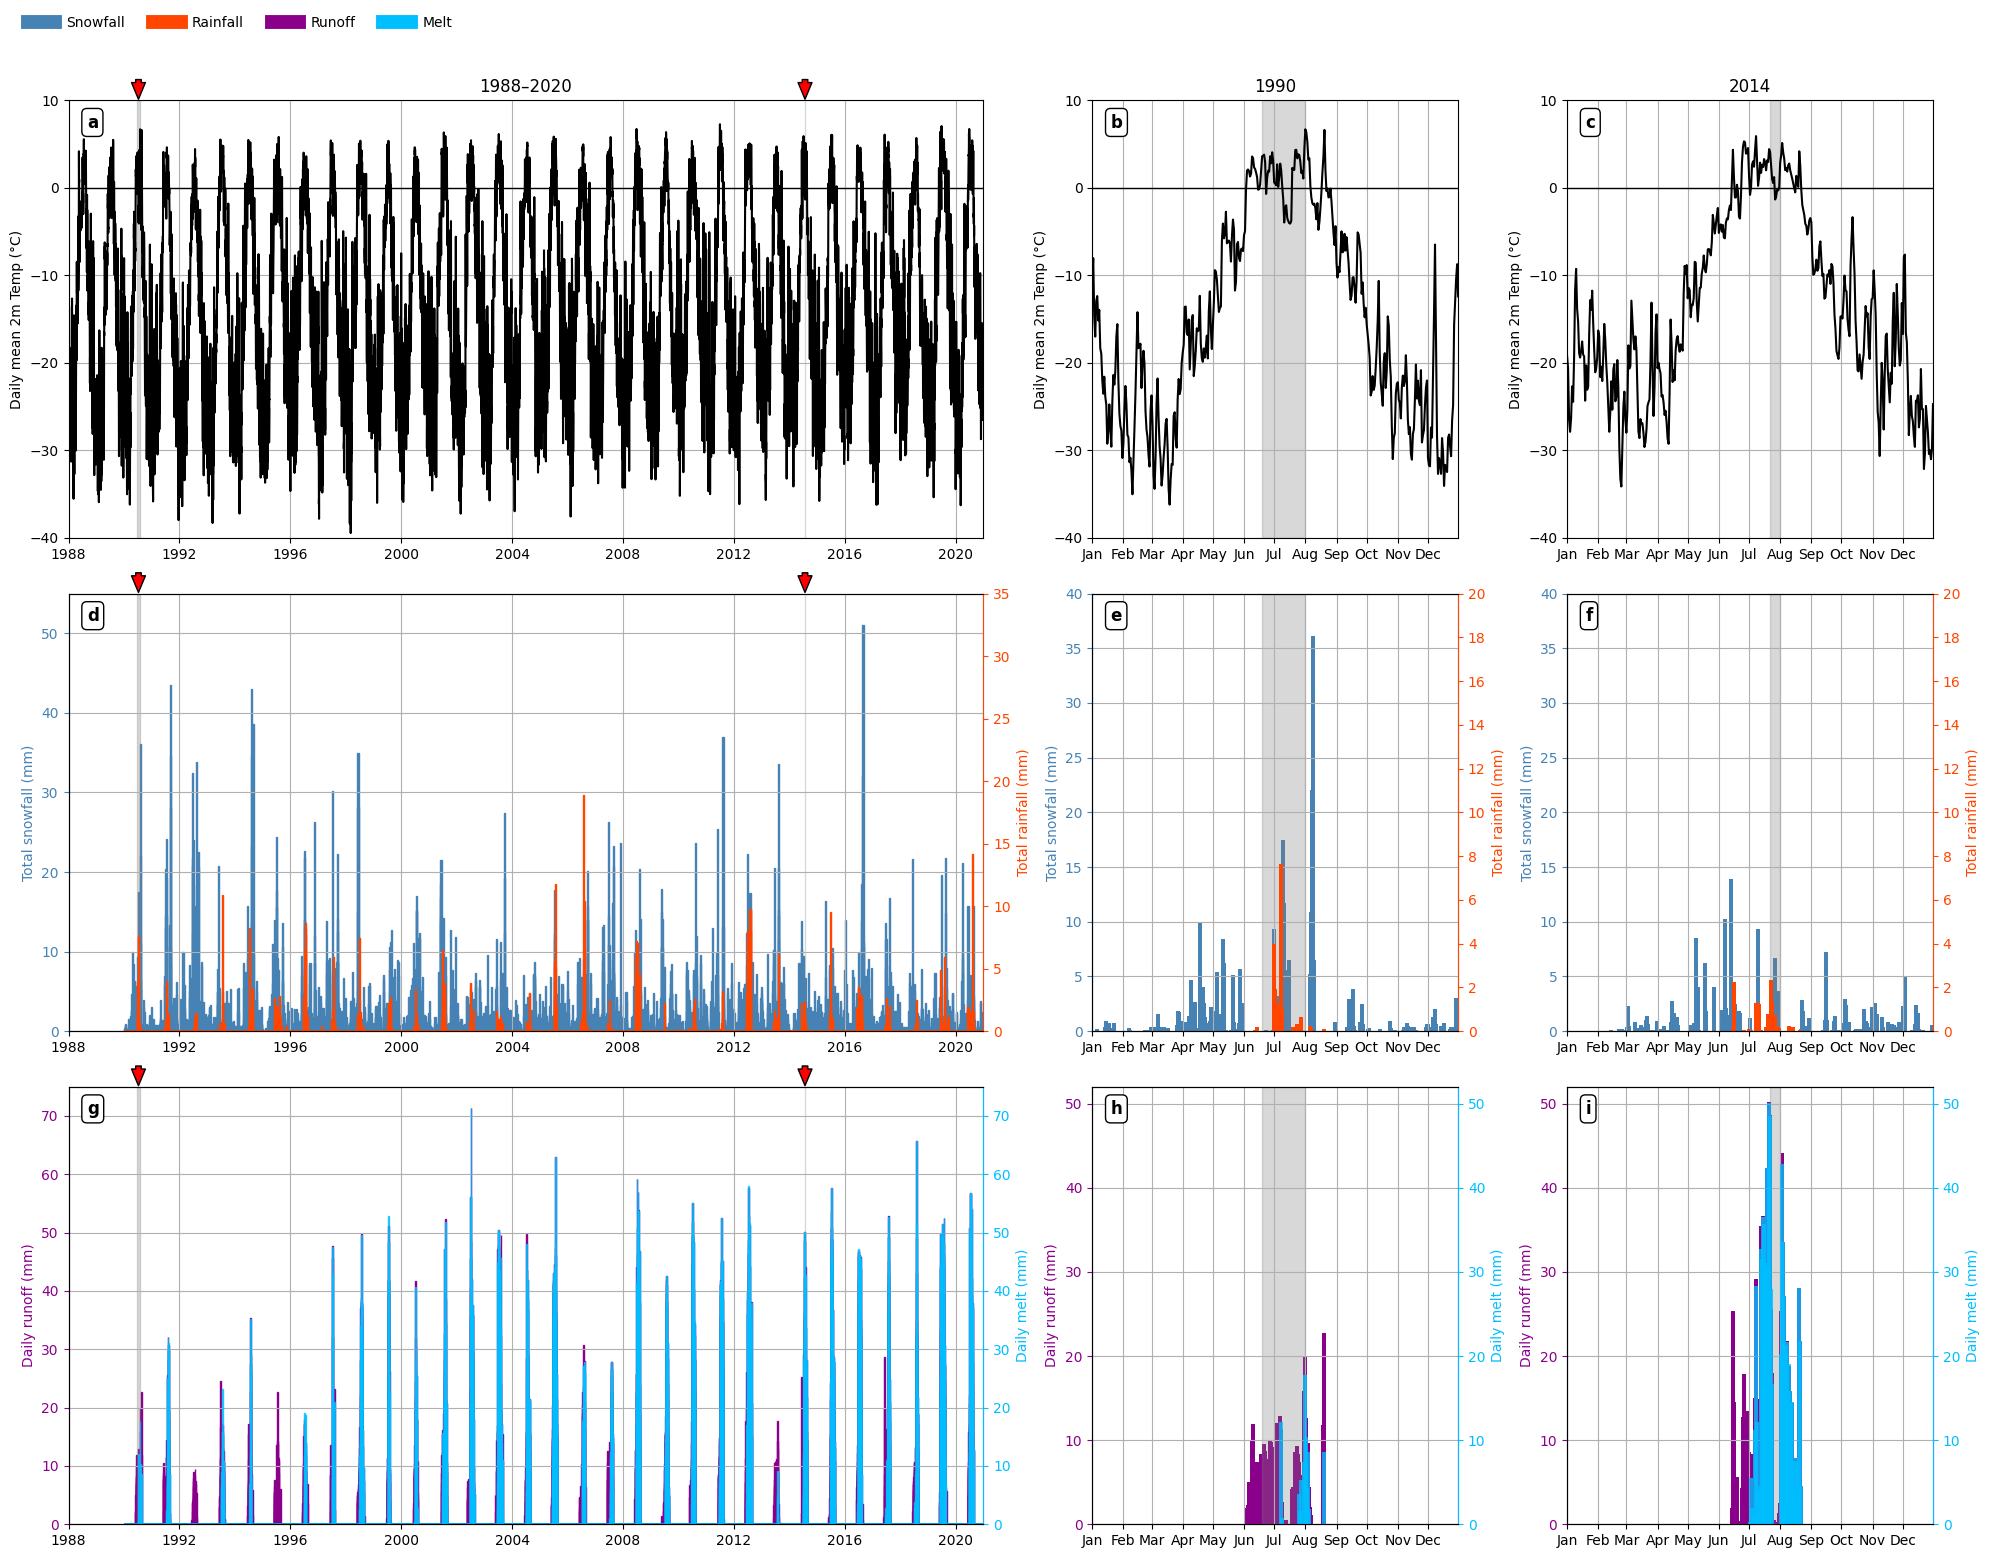

In [66]:
# Create figure with custom gridspec layout
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(3, 3, width_ratios=[2.5, 1, 1])
month_locator = mdates.MonthLocator(bymonth=range(1, 13))
month_formatter = mdates.DateFormatter('%b')

temp_color = 'black'
snowfall_color = 'steelblue'
rainfall_color = 'orangered'
runoff_color = 'darkmagenta'
melt_color = 'deepskyblue'

# --- Row 1: 2m Daily Temperature plots ---
# Surface temperature — 1990–2020
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df_temp["time"], df_temp["t2m_C"], color=temp_color)
ax1.axhline(0, color='black', linestyle='-', linewidth=1)
ax1.set_title("1988–2020")
ax1.set_ylabel("Daily mean 2m Temp (°C)")
ax1.set_xlim(start_date, end_date)
ax1.set_ylim(-40,10)
ax1.grid(True)

# Surface temperature — 1990
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(df_1990["time"], df_1990["t2m_C"], color=temp_color)
ax2.axhline(0, color='black', linestyle='-', linewidth=1)
ax2.set_title("1990")
ax2.set_ylabel("Daily mean 2m Temp (°C)")
ax2.set_xlim(datetime(1990,1,1), datetime(1990,12,31))
ax2.xaxis.set_major_locator(month_locator)
ax2.xaxis.set_major_formatter(month_formatter)
ax2.set_xticks([datetime(1990, m, 1) for m in range(1, 13)])
ax2.tick_params(axis='x', which='both', rotation=0, labelsize=10)
ax2.set_ylim(-40,10)
ax2.grid(True)

# Surface temperature — 2020
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(df_2014["time"], df_2014["t2m_C"], color=temp_color)
ax3.axhline(0, color='black', linestyle='-', linewidth=1)
ax3.set_title("2014")
ax3.set_ylabel("Daily mean 2m Temp (°C)")
ax3.set_xlim(datetime(2014,1,1), datetime(2014,12,31))
ax3.set_xticks([datetime(2014, m, 1) for m in range(1, 13)])
ax3.set_ylim(-40,10)
ax3.grid(True)

# --- Row 2: Snowfall & Rainfall as dual-axis bar plots ---
# Snowfall & Rainfall — 1990–2020
ax4 = fig.add_subplot(gs[1, 0])
ax4.bar(df_snow_rain["time"], df_snow_rain["snowfall"], width=15.0, color=snowfall_color, edgecolor=snowfall_color, label='Snowfall')
ax4.set_ylabel("Total snowfall (mm)")
ax4.set_xlim(start_date, end_date)
ax4.set_ylim(0,55)
ax4.grid(True)
ax4.tick_params(axis='y', colors=snowfall_color)
ax4.spines['right'].set_color(snowfall_color)
ax4.yaxis.label.set_color(snowfall_color)

ax4b = ax4.twinx()
ax4b.bar(df_snow_rain["time"], df_snow_rain["precip"]-df_snow_rain["snowfall"], width=15.0, color=rainfall_color, edgecolor=rainfall_color, label='Rainfall')
ax4b.set_ylim(0,35)
ax4b.tick_params(axis='y', colors=rainfall_color)
ax4b.spines['right'].set_color(rainfall_color)
ax4b.yaxis.label.set_color(rainfall_color)
ax4b.set_ylabel("Total rainfall (mm)", rotation=90)

# Snowfall & Rainfall — 1990
ax5 = fig.add_subplot(gs[1, 1])
ax5.bar(df_1990["time"], df_1990["snowfall"], width=4.0, color=snowfall_color)
ax5.set_xlim(datetime(1990,1,1), datetime(1990,12,31))
ax5.xaxis.set_major_locator(month_locator)
ax5.xaxis.set_major_formatter(month_formatter)
ax5.set_xticks([datetime(1990, m, 1) for m in range(1, 13)])
ax5.tick_params(axis='x', which='both', rotation=0, labelsize=10)
ax5.set_ylim(0,40)
ax5.set_ylabel("Total snowfall (mm)")
ax5.tick_params(axis='y', colors=snowfall_color)
ax5.spines['right'].set_color(snowfall_color)
ax5.yaxis.label.set_color(snowfall_color)
ax5.grid(True)

ax5b = ax5.twinx()
ax5b.bar(df_1990["time"], df_1990["precip"]-df_1990["snowfall"], width=4.0, color=rainfall_color)
ax5b.set_ylim(0,20)
ax5b.set_ylabel("Total rainfall (mm)", rotation=90)
ax5b.tick_params(axis='y', colors=rainfall_color)
ax5b.spines['right'].set_color(rainfall_color)
ax5b.yaxis.label.set_color(rainfall_color)
ax5b.yaxis.set_major_locator(MaxNLocator(integer=True))

# Snowfall & Rainfall — 2014
ax6 = fig.add_subplot(gs[1, 2])
ax6.bar(df_2014["time"], df_2014["snowfall"], width=4.0, color=snowfall_color)
ax6.set_xlim(datetime(2014,1,1), datetime(2014,12,31))
ax6.set_xticks([datetime(2014, m, 1) for m in range(1, 13)])
ax6.set_ylim(0,40)
ax6.set_ylabel("Total snowfall (mm)")
ax6.grid(True)
ax6.tick_params(axis='y', colors=snowfall_color)
ax6.spines['right'].set_color(snowfall_color)
ax6.yaxis.label.set_color(snowfall_color)

ax6b = ax6.twinx()
ax6b.bar(df_2014["time"], df_2014["precip"]-df_2014["snowfall"], width=4.0, color=rainfall_color)
ax6b.set_ylim(0,20)
ax6b.set_ylabel("Total rainfall (mm)", rotation=90)
ax6b.tick_params(axis='y', colors=rainfall_color)
ax6b.spines['right'].set_color(rainfall_color)
ax6b.yaxis.label.set_color(rainfall_color)
ax6b.yaxis.set_major_locator(MaxNLocator(integer=True))

# --- Row 3: Melt & Runoff bar plots ---
# Daily Runoff & Melt — 1990–2020
ax7 = fig.add_subplot(gs[2, 0])
ax7b = ax7.twinx()
ax7b.bar(df_runoff_melt["time"], df_runoff_melt["snowmelt"], width=10.0, color=melt_color, edgecolor=melt_color, label='Melt', alpha=0.8)
ax7b.set_ylabel("Daily melt (mm)", rotation=90)
ax7b.set_ylim(0,75)
ax7b.tick_params(axis='y', colors=melt_color)
ax7b.spines['right'].set_color(melt_color)
ax7b.yaxis.label.set_color(melt_color)

ax7.bar(df_runoff_melt["time"], df_runoff_melt["runoff"], width=10.0, color=runoff_color, edgecolor=runoff_color, label='Runoff')
ax7.set_ylabel("Daily runoff (mm)")
ax7.set_xlim(start_date, end_date)
ax7.set_ylim(0,75)
ax7.grid(True)
ax7.tick_params(axis='y', colors=runoff_color)
ax7.spines['right'].set_color(runoff_color)
ax7.yaxis.label.set_color(runoff_color)

# Runoff & Melt — 1990
ax8 = fig.add_subplot(gs[2, 1])
ax8b = ax8.twinx()
ax8b.set_ylabel("Daily melt (mm)", rotation=90)
ax8b.bar(df_1990["time"], df_1990["snowmelt"], width=4.0, color=melt_color, alpha=0.8)
ax8b.set_ylim(0,52)
ax8b.tick_params(axis='y', colors=melt_color)
ax8b.spines['right'].set_color(melt_color)
ax8b.yaxis.label.set_color(melt_color)

ax8.bar(df_1990["time"], df_1990["runoff"], width=4.0, color=runoff_color)
ax8.set_xlim(datetime(1990,1,1), datetime(1990,12,31))
ax8.xaxis.set_major_locator(month_locator)
ax8.xaxis.set_major_formatter(month_formatter)
ax8.set_xticks([datetime(1990, m, 1) for m in range(1, 13)])
ax8.tick_params(axis='x', which='both', rotation=0, labelsize=10)
ax8.set_ylabel("Daily runoff (mm)")
ax8.set_ylim(0,52)
ax8.grid(True)
ax8.tick_params(axis='y', colors=runoff_color)
ax8.spines['right'].set_color(runoff_color)
ax8.yaxis.label.set_color(runoff_color)

# Runoff & Melt — 2014
ax9 = fig.add_subplot(gs[2, 2])
ax9b = ax9.twinx()
ax9b.bar(df_2014["time"], df_2014["snowmelt"], width=4.0, color=melt_color, alpha=0.8)
ax9b.set_ylim(0,52)
ax9b.set_ylabel("Daily melt (mm)", rotation=90)
ax9b.tick_params(axis='y', colors=melt_color)
ax9b.spines['right'].set_color(melt_color)
ax9b.yaxis.label.set_color(melt_color)

ax9.bar(df_2014["time"], df_2014["runoff"], width=4.0, color=runoff_color)
ax9.set_xlim(datetime(2014,1,1), datetime(2014,12,31))
ax9.set_xticks([datetime(2014, m, 1) for m in range(1, 13)])
ax9.set_ylim(0,52)
ax9.set_ylabel("Daily runoff (mm)", rotation=90)
ax9.grid(True)
ax9.tick_params(axis='y', colors=runoff_color)
ax9.spines['right'].set_color(runoff_color)
ax9.yaxis.label.set_color(runoff_color)

# Tidy date axis
for ax in [ax3, ax6, ax9]:
    ax.xaxis.set_major_locator(month_locator)
    ax.xaxis.set_major_formatter(month_formatter)
    ax.tick_params(axis='x', which='both', rotation=0, labelsize=10)

# Draw drainage events
for event in events:
    draw_grey_bar(ax1, event["start"], event["end"])
    draw_grey_bar(ax4, event["start"], event["end"])
    draw_grey_bar(ax7, event["start"], event["end"])
    draw_red_arrow(ax1, event["start"], event["end"])
    draw_red_arrow(ax4, event["start"], event["end"])
    draw_red_arrow(ax7, event["start"], event["end"])

    if event["start"].year == 1990:
        draw_grey_bar(ax2, event["start"], event["end"])
        draw_grey_bar(ax5, event["start"], event["end"])
        draw_grey_bar(ax8, event["start"], event["end"])

    if event["start"].year == 2014:
        draw_grey_bar(ax3, event["start"], event["end"])
        draw_grey_bar(ax6, event["start"], event["end"])
        draw_grey_bar(ax9, event["start"], event["end"])

fig.legend(
    handles=[
        plt.Line2D([], [], color=snowfall_color, lw=10, label='Snowfall'),
        plt.Line2D([], [], color=rainfall_color, lw=10, label='Rainfall'),
        plt.Line2D([], [], color=runoff_color, lw=10, label='Runoff'),
        plt.Line2D([], [], color=melt_color, lw=10, label='Melt')
    ],
    loc='upper left',
    bbox_to_anchor=(0.01, 1.04),
    ncol=4,
    frameon=False
)

figure_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i, (ax, label) in enumerate(zip(axes, figure_labels)):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Identify first column (i = 0, 3, 6)
    if i % 3 == 0:
        x_offset = (xlim[1] - xlim[0]) * 0.02  # Smaller for wide plots
    else:
        x_offset = (xlim[1] - xlim[0]) * 0.05

    y_offset = (ylim[1] - ylim[0]) * 0.03

    ax.text(
        xlim[0] + x_offset, ylim[1] - y_offset, label,
        fontsize=12, fontweight='bold', ha='left', va='top',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )

plt.tight_layout()
plt.savefig("ExtendedData_FigS1.png", dpi=300)
plt.savefig("ExtendedData_FigS1.svg", format='svg', bbox_inches='tight')
plt.show()

